In [1]:
import pandas as pd
import sklearn.metrics as metrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc

In [2]:
# 数据预处理
# 菌群数据
data = pd.read_csv("data_1_total.csv")  # 训练集
data_test = pd.read_csv("data_1_33.csv")  # 测试集
Feature_importance_data = pd.read_csv("Feature_Importance_data1_total.csv")  # 训练集提取的特征
Feature_importance_data_test = pd.read_csv("Feature_Importance_data1_33.csv")  # 测试集提取的特征

# 以列表形式存储特征
feature = Feature_importance_data[Feature_importance_data.columns[0]].tolist()
feature_test = Feature_importance_data_test[Feature_importance_data_test.columns[0]].tolist()

# 消除两个样本中不一样的特征
for tmp in feature:
    if tmp not in feature_test:
        feature.remove(tmp)

for tmp in feature_test:
    if tmp not in feature:
        feature_test.remove(tmp)

# 划分特征组
list_feature = []
x = []
min_num = 1  # 最少特征
max_num = 100  # 最多特征
split = 1  # 分隔
for i in range(min_num, max_num, split):
    list1 = feature[:i]
    list_feature.append(list1)
    x.append(i)

# 训练模型

In [3]:
svm_score = []  # 存储每个划分子集的得分
svm_analysis = []  # svm分析结果

In [12]:
def svm_test(train_X, train_Y, test_X, test_Y, svm):
    '''
    svm 训练函数
    :param train_X:训练集
    :param train_Y:
    :param test_X:测试集
    :param test_Y:
    :param svm:svm模型
    :return:[0:svm soore, 1:SVM Accuracy_Score, 2:SVM Precision, 3:SVM Recall, 4:SVM F1 - Score, 5:SVM AUC value, 6,7,8:roc曲线参数]
    '''
    temp = []  # 存储模型输出结果
    # 0均值标准化
    ss = StandardScaler()
    train_X = ss.fit_transform(train_X)
    test_X = ss.fit_transform(test_X)

    # 创建svm分类器
    random_state = np.random.RandomState(0)

    svm = svm.SVC(kernel='linear', probability=True, random_state=random_state)
    svm.fit(train_X, train_Y)

    # 预测测试集分类结果
    predict_Y = svm.predict(test_X)

    # 评估模型

    # 交叉验证
    score_lyst = cross_val_score(svm, test_X, test_Y, cv =10)
    print(score_lyst)

    # 0:SVM Score
    score = svm.score(test_X, test_Y)

    # print("Svm Score : score = %f " % score)
    temp.append(score)
    svm_score.append(score)

    # 1:SVM Accuracy_Score
    accuracy = metrics.accuracy_score(test_Y, predict_Y)
    # print("Svm Accuracy：accuracy = %f" % accuracy)
    temp.append(accuracy)

    # 2:SVM Precision
    precision = metrics.precision_score(test_Y, predict_Y)
    # print("Svm Precision：precision = %f" % precision)
    temp.append(precision)

    # 3:SVM Recall
    recall = metrics.recall_score(test_Y, predict_Y)
    # print("Svm Recall：recall = %f" % recall)
    temp.append(recall)

    # 4:SVM F1 - Score
    f1_score = metrics.f1_score(test_Y, predict_Y)
    # print("Svm Recall：f1_score = %f" % f1_score)
    temp.append(f1_score)

    # 5:SVM AUC value
    auc = metrics.roc_auc_score(test_Y, predict_Y)
    # print("SVM AUC value：auc = %f" % auc)
    temp.append(auc)

    # 6,7,8 roc曲线参数
    fpr, tpr, thershold = roc_curve(test_Y, predict_Y)
    temp.append(fpr)  # 6
    temp.append(tpr)  # 7
    temp.append(thershold)  # 8

    return temp


In [13]:
for i in range(len(list_feature)):
    # 循环训练模型
    # 使用各自的样本集，使用split函数做划分，训练集与测试集划分比例4：1
    global svm
    train, test = train_test_split(data, test_size=0.2, random_state=7)
    train_X = train[list_feature[i]]
    train_Y = train['sample']
    test_X = test[list_feature[i]]
    test_Y = test['sample']
    svm_analysis.append(svm_test(train_X, train_Y, test_X, test_Y, svm))

NameError: name 'cross_val_score' is not defined

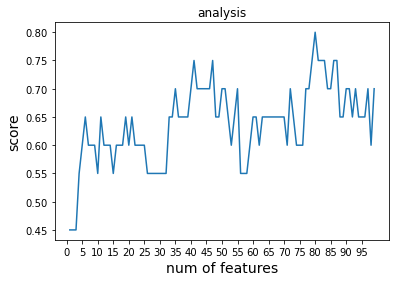

In [6]:
# 训练曲线
plt.plot(x, svm_score)
plt.title("analysis")
plt.xlabel("num of features", fontsize=14)
plt.ylabel("score", fontsize=14)
plt.xticks(np.arange(0, 100, 5))
plt.show()


In [7]:
# 获取使得模型效果最好的特征数量
best = svm_score.index(max(svm_score))
print(best, svm_score[best])

79 0.8


<Figure size 432x288 with 0 Axes>

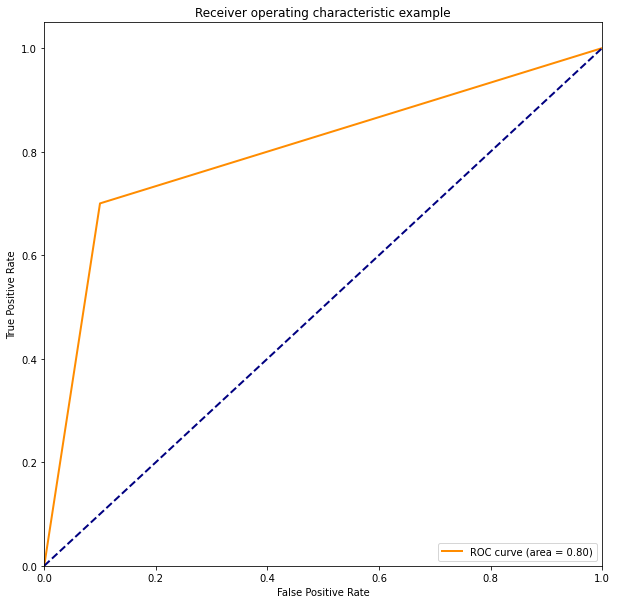

In [8]:
# 绘制ROC曲线
fpr = svm_analysis[best][6]
tpr = svm_analysis[best][7]
thershold = svm_analysis[best][8]
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)  ##假正率为横坐标，真正率为纵坐标做曲线

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


In [9]:
# 特征稳定的数量在验证集中的准确性与ROC曲线
# 循环训练模型
# 使用另一个样本集做验证，使用split函数做划分，训练集与测试集划分比例4：1
train, test = train_test_split(data_test, test_size=0.2, random_state=19)
train_X = train[list_feature[best]]
train_Y = train['sample']
test_X = test[list_feature[best]]
test_Y = test['sample']
temp_test = svm_test(train_X, train_Y, test_X, test_Y, svm)
print(temp_test[0])  # 输出测试集准确率


0.42857142857142855
